# Setting of Analysis
> **1. Import Library**  
> **2. Data Loading**  [(Data Source and Description)](https://www.kaggle.com/c/bike-sharing-demand/data)  
> **3. Feature Engineering(Rearrange of Data)**  
> **4. Split of Data: Train, Validate, Test Sets**  
> **5. Descriptive Statistics and Getting Insight from Features**  
> **6. Applying Models**  
> **7. Evaluation**  
> **8. Error Analysis**  

In [5]:
!python -m pip install --upgrade pip
!pip install xgboost
!pip install lightgbm
!pip install pyramid-arima

Requirement already up-to-date: pip in c:\programdata\anaconda3\lib\site-packages (18.1)


In [6]:
import warnings
warnings.filterwarnings("ignore")
import os
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile
import pandas as pd
import numpy as np
pd.options.display.float_format = '{:,.4f}'.format
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

url_all = 'https://raw.githubusercontent.com/cheonbi/DataScience/master/Time_Series_Analysis_with_Python/Data/all.csv'
raw_all = pd.read_csv(url_all)
raw_all.head()

raw_all['temp_group'] = pd.cut(raw_all['temp'], 10)
if 'datetime' in raw_all.columns:
    raw_all['DateTime'] = pd.to_datetime(raw_all['datetime'])
    del raw_all['datetime']
raw_all['Year'] = raw_all.DateTime.dt.year
raw_all['Quater'] = raw_all.DateTime.dt.quarter
raw_all['Quater_ver2'] = raw_all['Quater'] + (raw_all.Year - raw_all.Year.min()) * 4
raw_all['Month'] = raw_all.DateTime.dt.month
raw_all['Day'] = raw_all.DateTime.dt.day
raw_all['Hour'] = raw_all.DateTime.dt.hour
raw_all['DayofWeek'] = raw_all.DateTime.dt.dayofweek
raw_all.info()

if raw_all.index.dtype == 'int64':
    raw_all.set_index('DateTime', inplace=True)
display(raw_all.head())
# bring back
# if raw_all.index.dtype != 'int64':
#     raw_all.reset_index(drop=False, inplace=True)
# display(raw_all.head())

# Setting of X and Y
Y_colname = ['count']
X_remove = ['casual', 'registered']
X_colname = [x for x in raw_all.columns if x not in Y_colname+X_remove]

# if the data is not a time-series
# from sklearn.model_selection import train_test_split
# raw_train, raw_test = train_test_split(raw_all, test_size=0.2, random_state=123)
# print(raw_train.shape, raw_test.shape)

# X_train, X_test, Y_train, Y_test = train_test_split(raw_all[X_colname], raw_all[Y_colname], test_size=0.2, random_state=123)
# print(X_train.shape, Y_train.shape)
# print(X_test.shape, Y_test.shape)

# if the data is a time-series
# raw_train = raw_all.loc[raw_all.Day < 20,:]
# raw_test = raw_all.loc[raw_all.Day >= 20,:]
# print(raw_train.shape, raw_test.shape)
# or
raw_train = raw_all.loc[raw_all.index < '2012-07-01',:]
raw_test = raw_all.loc[raw_all.index >= '2012-07-01',:]
print(raw_train.shape, raw_test.shape)

Y_train = raw_train[Y_colname]
X_train = raw_train[X_colname]
Y_test = raw_test[Y_colname]
X_test = raw_test[X_colname]
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

# Confirm of input and output
drop_column = ['temp_group']
# X_train.drop(columns=drop_column, inplace=True)
# X_test.drop(columns=drop_column, inplace=True)
# or
for sub_col in drop_column:
    if sub_col in X_train.columns:
        X_train.drop(columns=sub_col, inplace=True)
        X_test.drop(columns=sub_col, inplace=True)

from sklearn.linear_model import LinearRegression, Lasso, ElasticNet 
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# LinearRegression (using sklearn)
model_fit_reg1 = LinearRegression(fit_intercept=True, normalize=False).fit(X_train, Y_train)
# display(pd.concat([pd.DataFrame(X_train.columns, columns=['Features']), pd.DataFrame(model_fit_reg1.coef_, index=['Coefficients']).T], axis=1))
model_pred_tr_reg1 = model_fit_reg1.predict(X_train)
model_pred_te_reg1 = model_fit_reg1.predict(X_test)

# LinearRegression (using statsmodels)
model_fit_reg2 = sm.OLS(Y_train, X_train).fit()
# display(model_fit_reg2.summary())
model_pred_tr_reg2 = model_fit_reg2.predict(X_train)
model_pred_te_reg2 = model_fit_reg2.predict(X_test)

# Lasso
model_fit_reg3 = Lasso(alpha=0.5, fit_intercept=True, normalize=False, random_state=123).fit(X_train, Y_train)
model_pred_tr_reg3 = model_fit_reg3.predict(X_train)
model_pred_te_reg3 = model_fit_reg3.predict(X_test)

# ElasticNet
model_fit_reg4 = ElasticNet(alpha=0.1, l1_ratio=0.1, fit_intercept=True, normalize=False, random_state=123).fit(X_train, Y_train)
model_pred_tr_reg4 = model_fit_reg4.predict(X_train)
model_pred_te_reg4 = model_fit_reg4.predict(X_test)

# GradientBoostingRegression
model_fit_reg5 = GradientBoostingRegressor(alpha=0.1, learning_rate=0.05, loss='huber', criterion='friedman_mse',
                                           n_estimators=1000, random_state=123).fit(X_train, Y_train)
model_pred_tr_reg5 = model_fit_reg5.predict(X_train)
model_pred_te_reg5 = model_fit_reg5.predict(X_test)

# # XGBoost
# model_fit_reg6 = XGBRegressor(learning_rate=0.05, n_estimators=100, random_state=123).fit(X_train, Y_train)
# model_pred_tr_reg6 = model_fit_reg6.predict(X_train)
# model_pred_te_reg6 = model_fit_reg6.predict(X_test)

# LightGMB
model_fit_reg7 = LGBMRegressor(learning_rate=0.05, n_estimators=100, random_state=123).fit(X_train, Y_train)
model_pred_tr_reg7 = model_fit_reg7.predict(X_train)
model_pred_te_reg7 = model_fit_reg7.predict(X_test)

# RandomForestRegressor
model_fit_reg8 = RandomForestRegressor(n_estimators=100, random_state=123).fit(X_train, Y_train)
model_pred_tr_reg8 = model_fit_reg8.predict(X_train)
model_pred_te_reg8 = model_fit_reg8.predict(X_test)

# DecisionTree
from sklearn import tree
model_fit_reg9 = tree.DecisionTreeRegressor().fit(X_train, Y_train)
model_pred_tr_reg9 = model_fit_reg9.predict(X_train)
model_pred_te_reg9 = model_fit_reg9.predict(X_test)

# Evaluation(Functionalize)
def Evaluation(Y_real, Y_pred, graph_on=False):
    Y_pred = pd.DataFrame(Y_pred).values
    loss_length = len(Y_real) - len(Y_pred)
    if loss_length != 0:
        Y_real = Y_real[loss_length:]

    if graph_on == True:
        pd.concat([Y_real, pd.DataFrame(Y_pred, index=Y_real.index, columns=['prediction'])], axis=1).plot(kind='line', figsize=(20,6),
                                                                                                           xlim=(Y_real.index.min(),Y_real.index.max()),
                                                                                                           linewidth=3, fontsize=20)
        plt.title('Time Series of Target', fontsize=20)
        plt.xlabel('Index', fontsize=15)
        plt.ylabel('Target Value', fontsize=15)

#     sklearn.metrics.r2_score
#     sklearn.metrics.mean_absolute_error
#     sklearn.metrics.medial_absolute_error
#     sklearn.metrics.mean_squared_error
#     sklearn.metrics.mean_squared_log_error
    MAD = abs(Y_real - Y_pred).values.mean()
    MSE = ((Y_real - Y_pred)**2).values.mean()
    MAPE = (abs(Y_real - Y_pred)/Y_real*100).values.mean()
    Score = pd.DataFrame([MAD, MSE, MAPE], index=['MAD', 'MSE', 'MAPE'], columns=['Score']).T
    Residual = Y_real - Y_pred
    Residual.columns = ['Error']
    return Score, Residual

def Evaluation_TrTe(Y_real_tr, Y_pred_tr, Y_real_te, Y_pred_te, graph_on=False):
    Score_tr, Residual_tr = Evaluation(Y_real_tr, Y_pred_tr, graph_on=graph_on)
    Score_te, Residual_te = Evaluation(Y_real_te, Y_pred_te, graph_on=graph_on)
    Score_trte = pd.concat([Score_tr, Score_te], axis=0)
    Score_trte.index = ['Train', 'Test']
    return Score_trte, Residual_tr, Residual_te

Score7, Resid_tr_reg7, Resid_te_reg7 = Evaluation_TrTe(Y_train, model_pred_tr_reg7, Y_test, model_pred_te_reg7)
display(Score7)
Score8, Resid_tr_reg8, Resid_te_reg8 = Evaluation_TrTe(Y_train, model_pred_tr_reg8, Y_test, model_pred_te_reg8)
display(Score8)
Score9, Resid_tr_reg9, Resid_te_reg9 = Evaluation_TrTe(Y_train, model_pred_tr_reg9, Y_test, model_pred_te_reg9)
display(Score9)

# Error Analysis(Functionalize)
def Error_Analysis(Y_Data, Target_name, X_Data, graph_on=False):
    for x in Target_name:
        Target_name = x
    X_Data = X_Data.loc[Y_Data.index]

    if graph_on == True:
        ##### Error Analysis(Plot)
        Y_Data['RowNum'] = Y_Data.reset_index().index

        # Stationarity(Trend) Analysis
        sns.set(palette="muted", color_codes=True, font_scale=2)
        sns.lmplot(x='RowNum', y=Target_name, data=Y_Data, fit_reg='True', size=7, aspect=2, ci=99, sharey=True)
        del Y_Data['RowNum']

        # Normal Distribution Analysis
        figure, axes = plt.subplots(figsize=(16,8))
        sns.distplot(Y_Data[Target_name], norm_hist='True', fit=stats.norm)

        # Lag Analysis
        length = int(len(Y_Data[Target_name])/10)
        figure, axes = plt.subplots(3, 2, figsize=(16,16))
        pd.plotting.lag_plot(Y_Data[Target_name].iloc[1:length], lag=1, ax=axes[0,0])
        pd.plotting.lag_plot(Y_Data[Target_name].iloc[1:length], lag=2, ax=axes[0,1])
        pd.plotting.lag_plot(Y_Data[Target_name].iloc[1:length], lag=3, ax=axes[1,0])
        pd.plotting.lag_plot(Y_Data[Target_name].iloc[1:length], lag=4, ax=axes[1,1])
        pd.plotting.lag_plot(Y_Data[Target_name].iloc[1:length], lag=10, ax=axes[2,0])
        pd.plotting.lag_plot(Y_Data[Target_name].iloc[1:length], lag=20, ax=axes[2,1])

        # Autocorrelation Analysis
        figure, axes = plt.subplots(2,1,figsize=(16,10))
        sm.graphics.tsa.plot_acf(Y_Data[Target_name].iloc[1:length], lags=100, use_vlines=True, ax=axes[0])
        sm.graphics.tsa.plot_pacf(Y_Data[Target_name].iloc[1:length], lags=100, use_vlines=True, ax=axes[1])      

    ##### Error Analysis(Statistics)
    # Checking Stationarity
    # Null Hypothesis: The Time-series is non-stationalry
    Stationarity = pd.Series(sm.tsa.stattools.adfuller(Y_Data[Target_name])[0:4],
                             index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
    for key, value in sm.tsa.stattools.adfuller(Y_Data[Target_name])[4].items():
        Stationarity['Critical Value(%s)'%key] = value
        Stationarity['Maximum Information Criteria'] = sm.tsa.stattools.adfuller(Y_Data[Target_name])[5]
        Stationarity = pd.DataFrame(Stationarity, columns=['Stationarity'])

    # Checking of Normality
    # Null Hypothesis: The residuals are normally distributed
    Normality = pd.DataFrame([stats.shapiro(Y_Data[Target_name])],
                             index=['Normality'], columns=['Test Statistics', 'p-value']).T

    # Checking for Autocorrelation
    # Null Hypothesis: Autocorrelation is absent
    Autocorrelation = pd.concat([pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Y_Data[Target_name], lags=[1,5,10,50])[0], columns=['Test Statistics']),
                                 pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Y_Data[Target_name], lags=[1,5,10,50])[1], columns=['p-value'])], axis=1).T
    Autocorrelation.columns = ['Autocorr(lag1)', 'Autocorr(lag5)', 'Autocorr(lag10)', 'Autocorr(lag50)']

    # Checking Heteroscedasticity
    # Null Hypothesis: Error terms are homoscedastic
    Heteroscedasticity = pd.DataFrame([sm.stats.diagnostic.het_goldfeldquandt(Y_Data[Target_name], X_Data.values, alternative='two-sided')],
                                      index=['Heteroscedasticity'], columns=['Test Statistics', 'p-value', 'Alternative']).T
    Score = pd.concat([Stationarity, Normality, Autocorrelation, Heteroscedasticity], join='outer', axis=1)
    Score = Score.loc[['Test Statistics', 'p-value', 'Alternative', 'Used Lag', 'Used Observations',
                       'Critical Value(1%)', 'Critical Value(5%)', 'Critical Value(10%)', 'Maximum Information Criteria'],:]
    return Score

Error_Analysis(Resid_tr_reg8, ['Error'], X_train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 20 columns):
season         17379 non-null int64
holiday        17379 non-null int64
workingday     17379 non-null int64
weather        17379 non-null int64
temp           17379 non-null float64
atemp          17379 non-null float64
humidity       17379 non-null int64
windspeed      17379 non-null float64
casual         17379 non-null int64
registered     17379 non-null int64
count          17379 non-null int64
temp_group     17379 non-null category
DateTime       17379 non-null datetime64[ns]
Year           17379 non-null int64
Quater         17379 non-null int64
Quater_ver2    17379 non-null int64
Month          17379 non-null int64
Day            17379 non-null int64
Hour           17379 non-null int64
DayofWeek      17379 non-null int64
dtypes: category(1), datetime64[ns](1), float64(3), int64(15)
memory usage: 2.5 MB


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,temp_group,Year,Quater,Quater_ver2,Month,Day,Hour,DayofWeek
DateTime,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.8400,14.3950,81,0.0000,3,13,16,"(8.856, 12.874]",2011,1,1,1,1,0,5
2011-01-01 01:00:00,1,0,0,1,9.0200,13.6350,80,0.0000,8,32,40,"(8.856, 12.874]",2011,1,1,1,1,1,5
2011-01-01 02:00:00,1,0,0,1,9.0200,13.6350,80,0.0000,5,27,32,"(8.856, 12.874]",2011,1,1,1,1,2,5
2011-01-01 03:00:00,1,0,0,1,9.8400,14.3950,75,0.0000,3,10,13,"(8.856, 12.874]",2011,1,1,1,1,3,5
2011-01-01 04:00:00,1,0,0,1,9.8400,14.3950,75,0.0000,0,1,1,"(8.856, 12.874]",2011,1,1,1,1,4,5


(13003, 19) (4376, 19)
(13003, 16) (13003, 1)
(4376, 16) (4376, 1)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:126: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


,MAD,MSE,MAPE
Train,25.0060,"1,360.5871",60.3094
Test,49.4532,"5,366.5208",51.2366


,MAD,MSE,MAPE
Train,8.2916,189.1715,11.7646
Test,47.4639,"5,358.4181",31.3604


,MAD,MSE,MAPE
Train,0.0000,0.0000,0.0000
Test,56.6394,"8,212.5069",36.8442


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,Stationarity,Normality,Autocorr(lag1),Autocorr(lag5),Autocorr(lag10),Autocorr(lag50),Heteroscedasticity
Test Statistics,-17.5399,0.8463,"1,578.0418","2,659.7878","2,994.9643","4,015.1028",1.5004
p-value,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Alternative,nan,nan,nan,nan,nan,nan,two-sided
Used Lag,23.0000,nan,nan,nan,nan,nan,NaN
Used Observations,"12,979.0000",nan,nan,nan,nan,nan,NaN
Critical Value(1%),-3.4309,nan,nan,nan,nan,nan,NaN
Critical Value(5%),nan,nan,nan,nan,nan,nan,NaN
Critical Value(10%),nan,nan,nan,nan,nan,nan,NaN
Maximum Information Criteria,"102,779.3620",nan,nan,nan,nan,nan,NaN


# Start Analysis
### [Setting of Analysis]  
> **1. Import Library**  
> **2. Data Loading**  [(Data Source and Description)](https://www.kaggle.com/c/bike-sharing-demand/data)  
> **3. Feature Engineering(Rearrange of Data)**  
> **4. Split of Data: Train, Validate, Test Sets**  
> **5. Descriptive Statistics and Getting Insight from Features**  
> **6. Applying Models**  
> **7. Evaluation**  
> **8. Error Analysis**  
### [Update and Repeat of Analysis]
> **3. Feature Engineering**  
* One-hot Encoding  
* Reshape
* Scaling  

> **4~5. Split of Data and Descriptive Statistics**  
![](https://i.stack.imgur.com/fXZ6k.png)  
> ### > Some specific considerations are needed due to the nature of time as an independent variable
* [Stationary](https://en.wikipedia.org/wiki/Stationary_process): it does not change its statistical properties over time, namely its mean, variance, and covariance.
    * Scaling/ Aggregation/ Smoothing/ Polynomial Fitting/ Moving Average(Rolling)/ Exponentially Weighted Moving Average(EWMA)/ Differencing/ Decomposition  
    ![](https://habrastorage.org/files/20c/9d8/a63/20c9d8a633ec436f91dccd4aedcc6940.png)
    ![](https://habrastorage.org/files/b88/eec/a67/b88eeca676d642449cab135273fd5a95.png)
    ![](https://habrastorage.org/files/2f6/1ee/cb2/2f61eecb20714352840748b826e38680.png)
* [Decomposition of Time Series](https://en.wikipedia.org/wiki/Decomposition_of_time_series)
    * [Offset Aliases](https://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases)
    * 'additive': the trend is more linear and the seasonality and trend components seem to be constant over time
    * (e.g. every year we add 100 units of energy production)
    * 'multiplicative': we are increasing (or decreasing) at a non-linear rate
    * (e.g. each year we double the amount of energy production everyyear)  
    
> **6. Applying Models**  
* ARIMA: there are 3 parameters(seasonality, trend, and noise) used to help model the major aspects of a times series. These parameters are labeled p,d,and q.
* Caution: A common mistake beginners make is they immediately start to apply time-series forecasting models to data that has many outside factors,
such as stock prices or a sports team’s performance. While ARIMA can be a powerful and relevant tool for times series related to those topics,
if you only use it by itself and don’t account for outside factors, such as a CEO getting fired or an injury on the team, you won’t have good results.
Keep this in mind as you begin to apply these concepts to your own data sets.  

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,Stationarity,Normality,Autocorr(lag1),Autocorr(lag5),Autocorr(lag10),Autocorr(lag50),Heteroscedasticity
Test Statistics,-26.6487,0.9690,"2,332.2078","4,110.6293","5,001.6349","24,744.1615",1.0374
p-value,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1389
Alternative,nan,nan,nan,nan,nan,nan,two-sided
Used Lag,40.0000,nan,nan,nan,nan,nan,NaN
Used Observations,"12,962.0000",nan,nan,nan,nan,nan,NaN
Critical Value(1%),-3.4309,nan,nan,nan,nan,nan,NaN
Critical Value(5%),nan,nan,nan,nan,nan,nan,NaN
Critical Value(10%),nan,nan,nan,nan,nan,nan,NaN
Maximum Information Criteria,"16,625.2624",nan,nan,nan,nan,nan,NaN


,Stationarity,Normality,Autocorr(lag1),Autocorr(lag5),Autocorr(lag10),Autocorr(lag50),Heteroscedasticity
Test Statistics,-19.2674,0.9765,"1,221.7620","2,049.0631","2,402.4425","11,254.6421",0.9965
p-value,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.9356
Alternative,nan,nan,nan,nan,nan,nan,two-sided
Used Lag,31.0000,nan,nan,nan,nan,nan,NaN
Used Observations,"4,344.0000",nan,nan,nan,nan,nan,NaN
Critical Value(1%),-3.4319,nan,nan,nan,nan,nan,NaN
Critical Value(5%),nan,nan,nan,nan,nan,nan,NaN
Critical Value(10%),nan,nan,nan,nan,nan,nan,NaN
Maximum Information Criteria,"4,082.1646",nan,nan,nan,nan,nan,NaN


C:\ProgramData\Anaconda3\lib\site-packages\pyramid\__init__.py:68: UserWarning: 
    The 'pyramid' package will be migrating to a new namespace beginning in 
    version 1.0.0: 'pmdarima'. This is due to a package name collision with the
    Pyramid web framework. For more information, see Issue #34:
    
        https://github.com/tgsmith61591/pyramid/issues/34
        
    The package will subsequently be installable via the name 'pmdarima'; the
    only functional change to the user will be the import name. All imports
    from 'pyramid' will change to 'pmdarima'.
    
  """, UserWarning)


Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=27943.321, BIC=27958.266, Fit time=0.763 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=25375.501, BIC=25397.920, Fit time=0.559 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=25837.966, BIC=25860.385, Fit time=1.114 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=25368.872, BIC=25398.764, Fit time=0.894 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds


C:\ProgramData\Anaconda3\lib\site-packages\pyramid\arima\auto.py:864: ModelFitWarning: Unable to fit ARIMA for order=(2, 0, 1) seasonal_order=(0, 0, 0, 1); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)


Fit ARIMA: order=(3, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=22738.005, BIC=22782.842, Fit time=17.119 seconds
Fit ARIMA: order=(4, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=22735.800, BIC=22788.110, Fit time=19.884 seconds
Fit ARIMA: order=(4, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=24555.999, BIC=24600.837, Fit time=1.927 seconds


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(4, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=22757.333, BIC=22817.117, Fit time=20.224 seconds
Fit ARIMA: order=(3, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=24834.116, BIC=24871.481, Fit time=1.178 seconds
Total fit time: 63.668 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                13003
Model:               SARIMAX(4, 0, 1)   Log Likelihood              -11360.900
Date:                Sat, 29 Dec 2018   AIC                          22735.800
Time:                        00:44:59   BIC                          22788.110
Sample:                             0   HQIC                         22753.278
                              - 13003                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.511e-05   1.93e-05      1.303      0.193   -1.27e-05    6.29e-05
ar.L1          1.2463      0.007    176.733      0.000       1.232       1.260
ar.L2         -0.2902      0.010    -27.756      0.000      -0.311      -0.270
ar.L3         -0.1952      0.012    -16.129      0.000      -0.219      -0.172
ar.L4          0.0237      0.009      2.597      0.009       0.006       0.042
ma.L1         -0.9973      0.001  -1412.190      0.000      -0.999      -0.996
sigma2         0.3352      0.003    117.007      0.000       0.330       0.341
===================================================================================
Ljung-Box (Q):                     5330.01   Jarque-Bera (JB):              6929.06
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.02   Skew:                            -0.29
Prob(H) (two-sided):                  0.60   Kurtosis:                         6.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

,MAD,MSE,MAPE
Train,45.4719,"5,954.5238",51.3344
Test,86.0725,"16,950.3833",54.4589


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,Stationarity,Normality,Autocorr(lag1),Autocorr(lag5),Autocorr(lag10),Autocorr(lag50),Heteroscedasticity
Test Statistics,-13.3010,0.8332,429.4771,916.3040,"2,719.3555","18,398.9049",1.6716
p-value,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Alternative,nan,nan,nan,nan,nan,nan,two-sided
Used Lag,40.0000,nan,nan,nan,nan,nan,NaN
Used Observations,"12,962.0000",nan,nan,nan,nan,nan,NaN
Critical Value(1%),-3.4309,nan,nan,nan,nan,nan,NaN
Critical Value(5%),nan,nan,nan,nan,nan,nan,NaN
Critical Value(10%),nan,nan,nan,nan,nan,nan,NaN
Maximum Information Criteria,"139,754.3890",nan,nan,nan,nan,nan,NaN


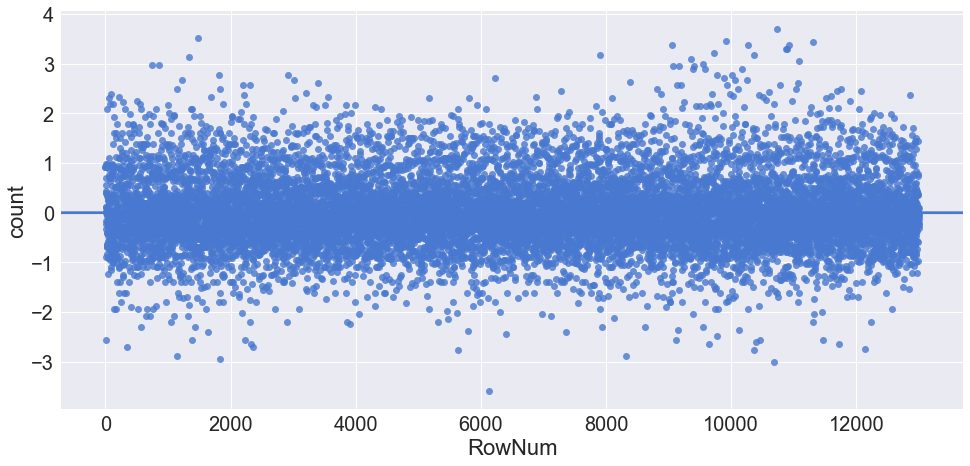

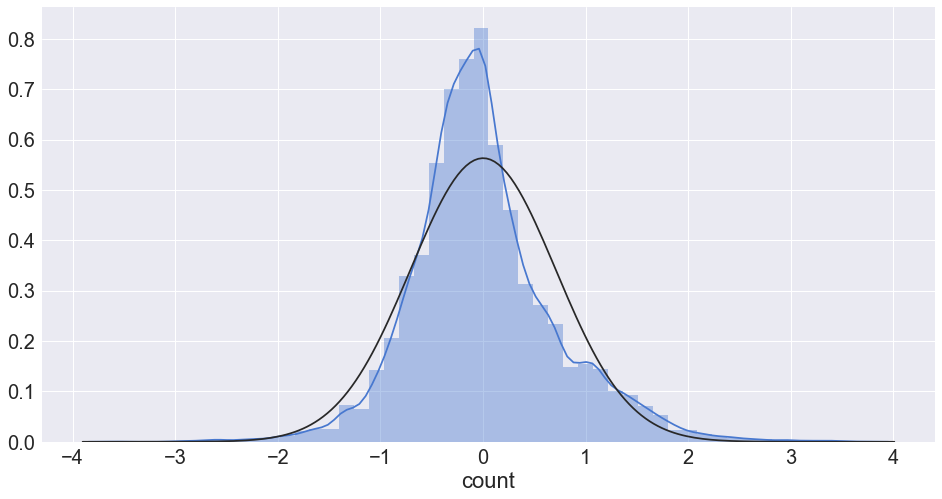

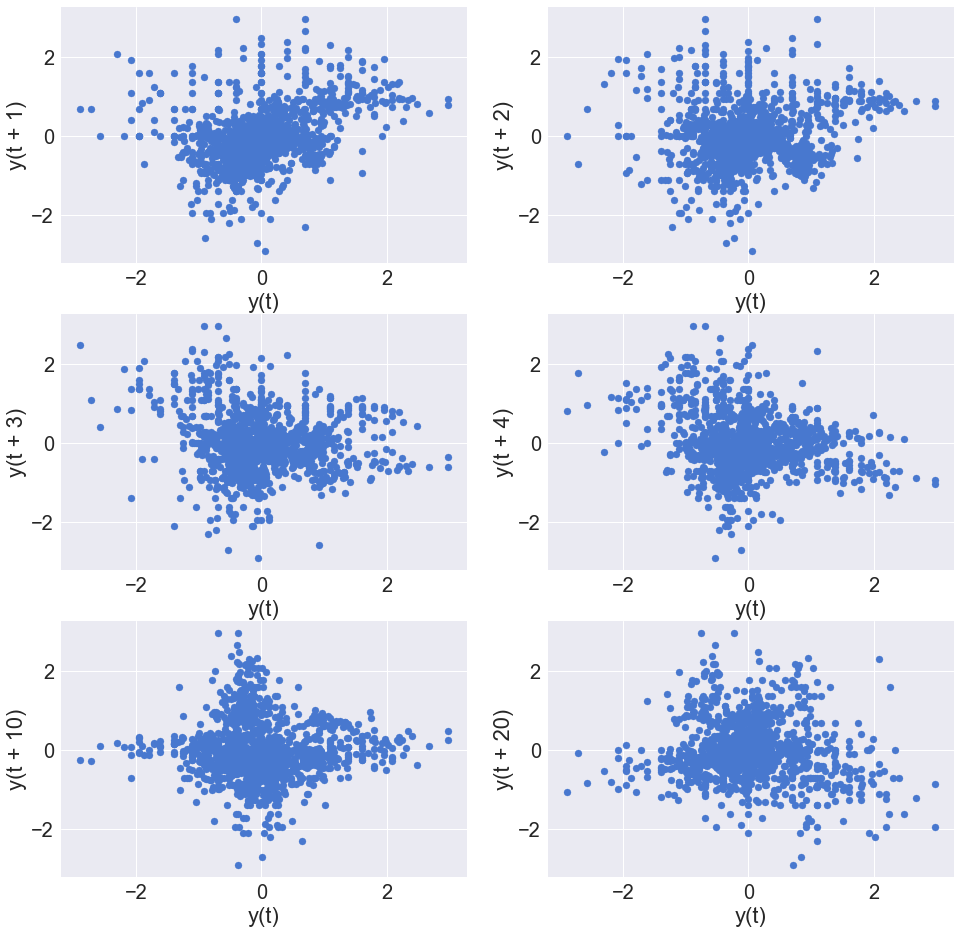

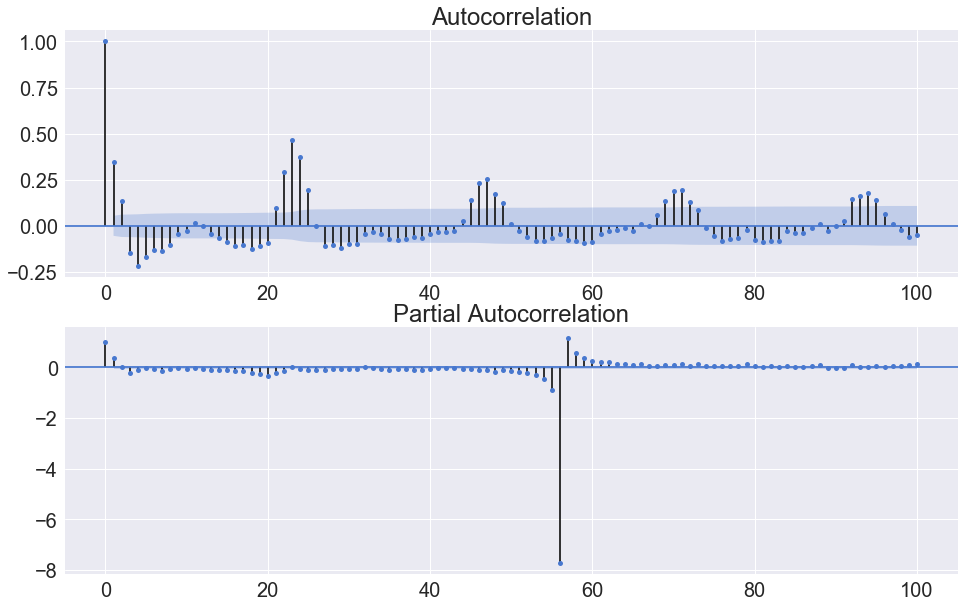

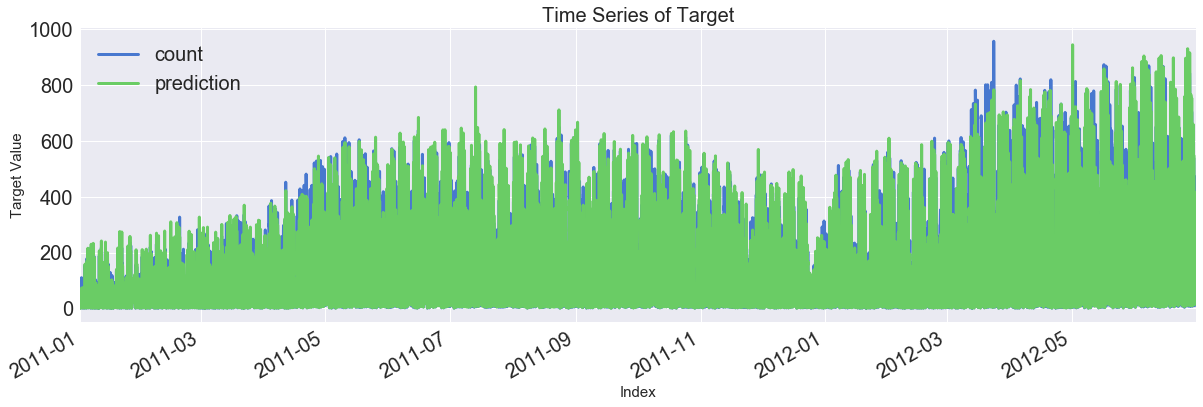

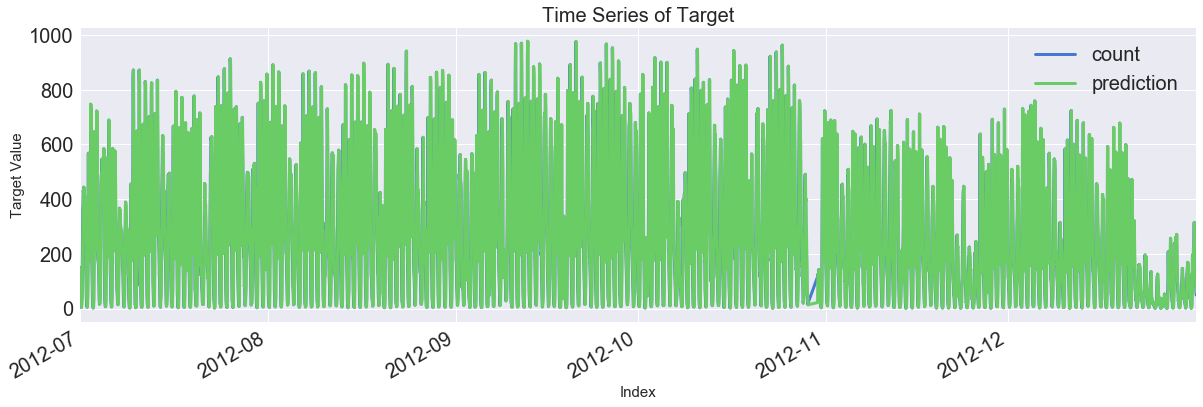

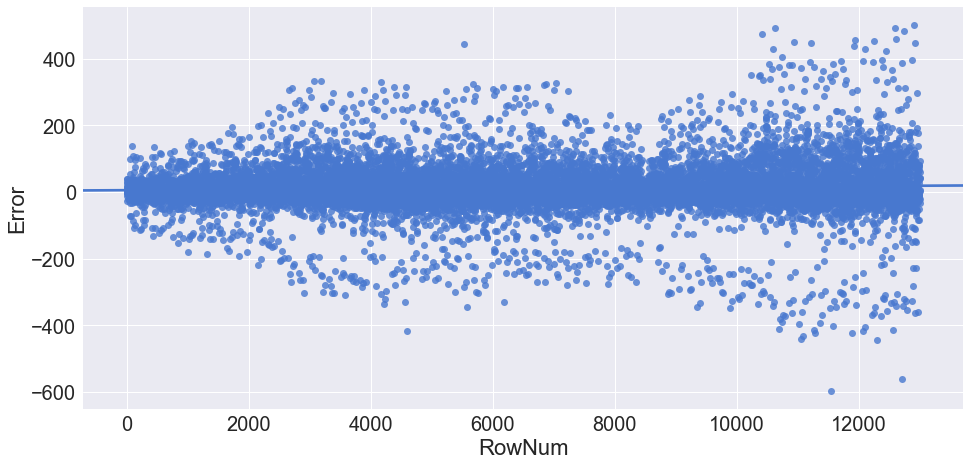

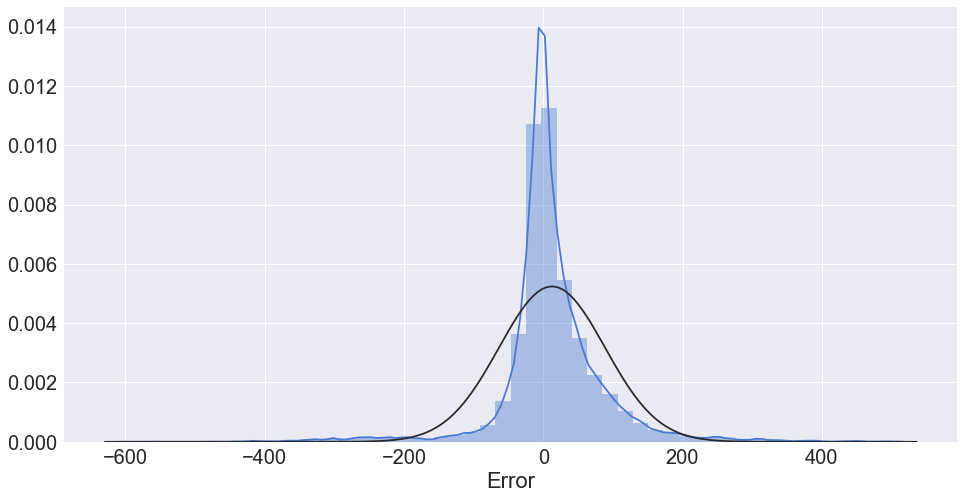

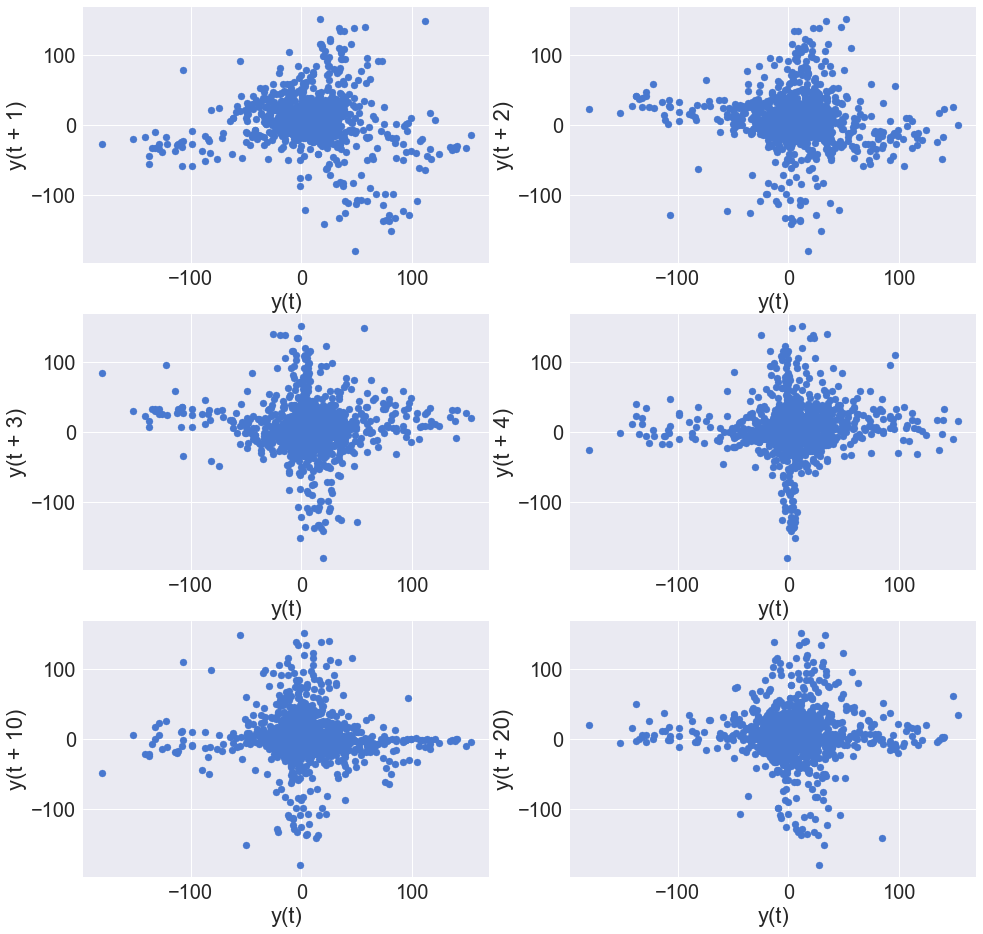

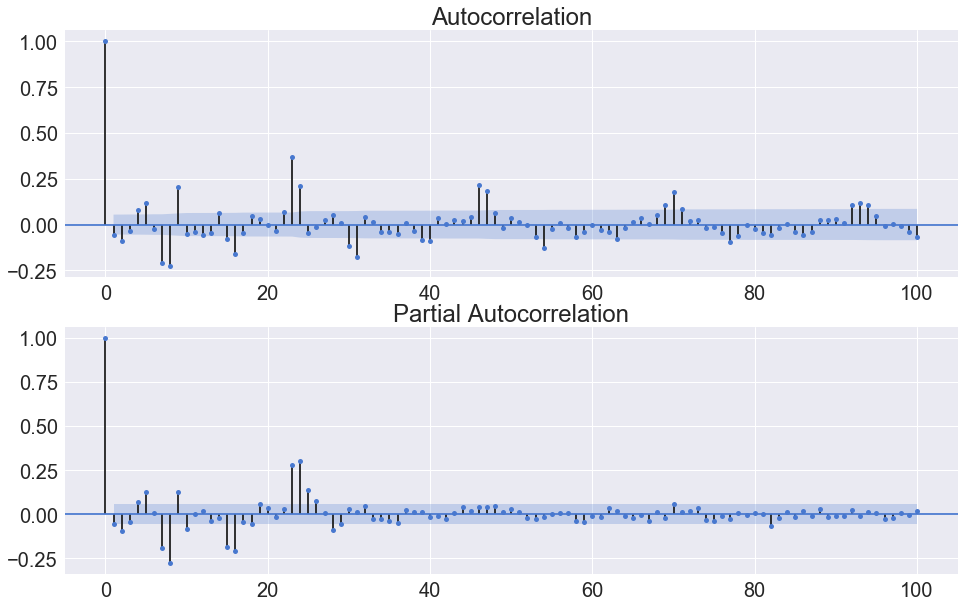

In [8]:
# Original Data
# print('Original Data')
# display(Error_Analysis(Y_train, ['count'], X_train, graph_on=True))

# Non-stationary -> Stationary
# print('Scaling')
# display(Error_Analysis(np.log(Y_train), ['count'], X_train))
# print('Moving Average')
# display(Error_Analysis(Y_train.rolling(24).mean().dropna(), ['count'], X_train))
# print('Y - Moving Average')
# display(Error_Analysis((Y_train-Y_train.rolling(24).mean()).dropna(), ['count'], X_train))
# print('Exponentially Weighted Moving Average')
# display(Error_Analysis(Y_train.ewm(com=0.5).mean(), ['count'], X_train))
# print('Y-Exponentially Weighted Moving Average')
# display(Error_Analysis((Y_train-Y_train.ewm(com=0.5).mean()), ['count'], X_train))
# print('Differencing')
# display(Error_Analysis((Y_train-Y_train.shift(periods=1)).dropna(), ['count'], X_train))

# Decomposition
# sm.tsa.seasonal_decompose(Y_train.asfreq(freq='H', method='ffill'), model='additive').plot()
# sm.tsa.seasonal_decompose(Y_train.asfreq(freq='H', method='ffill'), model='multiplicative').plot()

# Rescaling
Target_tr = Y_train.copy()
Target_te = Y_test.copy()
Rescaling = True
if Rescaling == False:
    Target_tr = Y_train.copy()
    Target_te = Y_test.copy()
else:
    # Target_log = np.log(Y_train)
    # Target_diff = (Target_log-Target_log.shift(periods=1)).dropna()
    # Target_ewma = Target_diff-Target_diff.ewm(com=0.1).mean()
    # Target_trend = sm.tsa.seasonal_decompose(Target_ewma.asfreq(freq='H', method='ffill'), model='additive').trend
    # Target_seasonal = sm.tsa.seasonal_decompose(Target_ewma.asfreq(freq='H', method='ffill'), model='additive').seasonal
    # Target_tr = (Target_ewma-Target_trend-Target_seasonal).dropna()
    # Target_log = np.log(Y_test)
    # Target_diff = (Target_log-Target_log.shift(periods=1)).dropna()
    # Target_ewma = Target_diff-Target_diff.ewm(com=0.1).mean()
    # Target_trend = sm.tsa.seasonal_decompose(Target_ewma.asfreq(freq='H', method='ffill'), model='additive').trend
    # Target_seasonal = sm.tsa.seasonal_decompose(Target_ewma.asfreq(freq='H', method='ffill'), model='additive').seasonal
    # Target_te = (Target_ewma-Target_trend-Target_seasonal).dropna()

    Target_log = np.log(Y_train)
    Target_tr = (Target_log-Target_log.shift(periods=1)).fillna(method='bfill')
    Target_log = np.log(Y_test)
    Target_te = (Target_log-Target_log.shift(periods=1)).fillna(method='bfill')
  
display(Error_Analysis(Target_tr, ['count'], X_train, graph_on=True))
display(Error_Analysis(Target_te, ['count'], X_test, graph_on=False))

# ARIMA model
# model_fit_time = sm.tsa.ARIMA(Target_tr, order=(0,0,1)).fit(trend='c', full_output=True, disp=True)
# display(model_fit_time.summary())
# model_pred_tr_time = np.array(model_fit_time.fittedvalues)
# model_pred_te_time = np.array(model_fit_time.forecast(steps=len(Target_te))[0])

# Auto-arima model
from pyramid.arima import auto_arima
model_fit_time = auto_arima(y=Target_tr, start_p=0, d=None, start_q=0, max_p=4, max_d=1, max_q=4,
                            start_P=0, D=None, start_Q=0, max_P=4, max_D=2, max_Q=4,
                            trend='c', seasonal=True, stepwise=True, random_state=123, trace=True).fit(Target_tr)
display(model_fit_time.summary())
model_pred_tr_time = model_fit_time.predict_in_sample()
model_pred_te_time = model_fit_time.predict(n_periods=len(Target_te))

# Backscaling
if Rescaling == True:
    model_pred_tr_time = np.exp(pd.DataFrame(model_pred_tr_time, index=Target_tr.index).values+np.log(Y_train).shift(periods=1).fillna(method='bfill'))
    model_pred_te_time = np.exp(pd.DataFrame(model_pred_te_time, index=Target_te.index).values+np.log(Y_test).shift(periods=1).fillna(method='bfill'))

# Evaluation and Error Analysis
Score_time, Resid_tr_time, Resid_te_time = Evaluation_TrTe(Y_train, model_pred_tr_time, Y_test, model_pred_te_time, graph_on=True)
display(Score_time)
display(Error_Analysis(Resid_tr_time, ['Error'], Y_train, graph_on=True))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=123, verbose=0, warm_start=False)
Accuracy(MAE):  47.463864259597806 degrees
Accuracy(MAPE):  68.6396366468004 %


,importance
Hour,0.607789
atemp,0.083328
temp,0.073734
Quater_ver2,0.056699
workingday,0.035738
DayofWeek,0.030655
humidity,0.024592
Year,0.022521
weather,0.021702
Day,0.013138


Text(0.5,1,'Variable Importances')

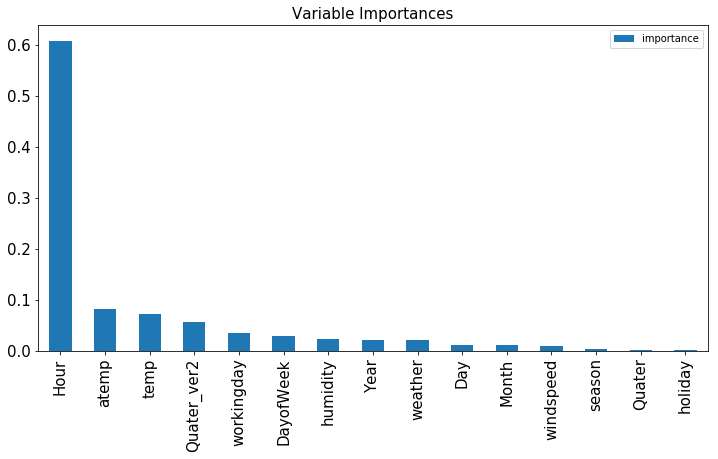

In [116]:
from sklearn.ensemble import RandomForestRegressor

model_fit = RandomForestRegressor(n_estimators=100, random_state=123).fit(X=X_train.values, y=Y_train.values.flatten())
print(model_fit)
model_prediction = model_fit.predict(X=X_test.values)

print('Accuracy(MAE): ', abs(model_prediction - Y_test.values.flatten()).mean(), 'degrees')
print('Accuracy(MAPE): ', (1-(abs(model_prediction - Y_test.values.flatten()) / Y_test.values.flatten()).mean())*100, '%')

# Insert Prediction Figure

Variable_Importances = pd.DataFrame([model_fit.feature_importances_], 
                                    columns=X_train.columns, 
                                    index=['importance']).T.sort_values(by=['importance'], ascending=False)
display(Variable_Importances)
Variable_Importances.plot.bar(figsize=(12,6), fontsize=15)
plt.title('Variable Importances', fontsize=15)